In [1]:
# Note: This is a hack to allow importing from the parent directory
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent / "submodules/resnet-18-autoencoder/src"))

# Note: Ignore warnings, be brave (YoLo)
import warnings

warnings.filterwarnings("ignore")

In [2]:
import torch
import matplotlib.pyplot as plt

from utils import noop_collate
from models import ResNetAutoencoder
from data import CIFAR10GaussianSplatsDataset
from constants import CIFAR10_TRANSFORM, CIFAR10_INVERSE_TRANSFORM, TENSOR_TRANSFORM, PIL_TRANSFORM
from classes.resnet_autoencoder import AE as DefaultResNetAutoencoder

plt.style.use("../style/main.mpltstyle")

In [3]:
def collect_samples_by_label(data, n_samples, test_loader, class_to_index, index_to_class):
    data = {k: [] for k in class_to_index.keys()}
    all_labels_filled = False  

    for batch in test_loader:
        if all_labels_filled:
            break  

        for image, index, splat in batch:
            label = index_to_class[index]
            if len(data[label]) < n_samples:
                data[label].append((image, splat))

            all_labels_filled = all(len(v) >= n_samples for v in data.values())
            if all_labels_filled:
                break  
            
    return data


In [4]:
N_SAMPLES = 1
CUSTOM_MODEL = None # TODO: ResNetAutoencoder()
DEFAULT_MODEL = DefaultResNetAutoencoder("light")
DEFAULT_MODEL.load_state_dict(torch.load("../models/default_resnet_autoencoder.ckpt")["model_state_dict"])

test_dataset = CIFAR10GaussianSplatsDataset(
    root="../data/CIFAR10GS",
    test=True,
    init_type="grid",
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=noop_collate,
)

CLASS_TO_INDEX = test_dataset.class_to_index
INDEX_TO_CLASS = {v: k for k, v in CLASS_TO_INDEX.items()}
DATA = collect_samples_by_label(test_dataset, N_SAMPLES, test_loader, CLASS_TO_INDEX, INDEX_TO_CLASS)
CUSTOM_RESULTS = {k: [] for k in CLASS_TO_INDEX.keys()}
DEFAULT_RESULTS = {k: [] for k in CLASS_TO_INDEX.keys()}

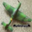

In [18]:
DATA["airplane"][0][0]

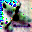

In [19]:
PIL_TRANSFORM(DEFAULT_MODEL(TENSOR_TRANSFORM(DATA["airplane"][0][0]))[0])

In [26]:
for label, samples in DATA.items():
    for image, splat in samples:
        if CUSTOM_MODEL:
            CUSTOM_RESULTS[label].append(CUSTOM_MODEL(image, splat))
        if DEFAULT_MODEL:
            DEFAULT_RESULTS[label].append(DEFAULT_MODEL(image, splat))

{'airplane': [(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
   ParameterDict(
       (Ks): Parameter containing: [torch.FloatTensor of size 3x3]
       (means): Parameter containing: [torch.FloatTensor of size 1024x3]
       (opacities): Parameter containing: [torch.FloatTensor of size 1024]
       (quats): Parameter containing: [torch.FloatTensor of size 1024x4]
       (scales): Parameter containing: [torch.FloatTensor of size 1024x3]
       (viewmats): Parameter containing: [torch.FloatTensor of size 4x4]
       (colors): Parameter containing: [torch.FloatTensor of size 1024x4x3]
   ))],
 'automobile': [(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
   ParameterDict(
       (Ks): Parameter containing: [torch.FloatTensor of size 3x3]
       (means): Parameter containing: [torch.FloatTensor of size 1024x3]
       (opacities): Parameter containing: [torch.FloatTensor of size 1024]
       (quats): Parameter containing: [torch.FloatTensor of size 1024x4]
   